In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 19 17:08:19 2024

@author: Rodrigo Meira
"""
from libs.eos_database import *
from libs.compressor_class import *
from libs.compression import *
from libs.gc_eos_soave import *
from libs.viscosity import *
from libs.plenum_system import *
from libs.simulation import *
from libs.model import *

from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
from sklearn.model_selection import train_test_split

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

vlv = valve(kv=0.38)
Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500, None, 1, 0, Aij, volumn_desviation, 'gas')
comp = CompressorClass()
visc = viscosity(mixture, volumn_desviation)
compressor = compression(gas, comp, visc)
plenum_sys = plenum(gas, compressor, vlv, Vpp, Lc, A1)

In [3]:
nAlphas = 300

sampler_N_RotS = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS = sampler_N_RotS.random(n=nAlphas+1)
N_RotS = qmc.scale(samples_N_RotS, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas = qmc.LatinHypercube(d=1)
samples_alphas = sampler_alphas.random(n=nAlphas+1)
alphas = qmc.scale(samples_alphas, 0.4, 0.65).flatten()

nData = 50
dt = 2
timestep = 3
x0 = [14.9919, 339.69, 0.42885]
z0 = [6245.39, 6245.39, 321.672, 0.445562, 319.423, 0.503621, 320.097, 0.396345, 339.69, 0.42885, 0.514917]
u0 = [4500, 300, 600, alphas[0], 5000]

In [4]:
# sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas, alphas, N_RotS, nData, dt, timestep)
# x_values, z_values, time_steps, alpha_values, N_values, x_train, y_train, x_min, x_max, y_min,y_max = sim.run()

# sim_data = {
#     "x_values": x_values,
#     "z_values": z_values,
#     "time_steps": time_steps,
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max

# }

# np.savez(
#     "simulation_data.npz",
#     x_values=x_values,
#     z_values=z_values,
#     time_steps=time_steps,
#     alpha_values=alpha_values,
#     N_values=N_values,
#     x_train=x_train,
#     y_train=y_train,
#     x_min=x_min,
#     x_max=x_max,
#     y_min = y_min,
#     y_max = y_max

# )


In [5]:
data = np.load("simulation_data.npz")

x_values = data["x_values"]
z_values = data["z_values"]
time_steps = data["time_steps"]
alpha_values = data["alpha_values"]
N_values = data["N_values"]
x_train = data["x_train"]
y_train = data["y_train"]
x_min = data["x_min"]
x_max = data["x_max"]
y_min = data["y_min"]
y_max = data["y_max"]


x_min = torch.tensor(x_min, dtype = torch.float32)
x_max = torch.tensor(x_max, dtype = torch.float32)
y_min = torch.tensor(y_min, dtype = torch.float32)
y_max = torch.tensor(y_max, dtype = torch.float32)
x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
y_train = torch.tensor(np.array(y_train), dtype=torch.float32)
x_train_split, X_val, y_train_split, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.3,  
    random_state=42,  
    shuffle=True      
)
y_train_split = y_train_split.squeeze()
y_val = y_val.squeeze()
train_dataset = torch.utils.data.TensorDataset(x_train_split, y_train_split)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= 64, shuffle=False)

In [6]:
model = MyModel(128, dt, x_max, x_min, y_min, y_max, plenum_sys)
train_loss_values = model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr= 1e-3,
    epochs=1,
    optimizers=torch.optim.Adam,
    patience=100,
    factor=0.5,
    gas = gas
)

/home/matheusmb/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


tensor(0.0204) tensor(0.0031) tensor(0.0040) tensor(0.0098) tensor(0.0001) tensor(0.0002) tensor(0.0221) tensor(8.0310e-08) tensor(0.0254) tensor(8.1563e-05) tensor(9.8242e-16)
tensor(0.0191) tensor(0.0028) tensor(0.0048) tensor(0.0117) tensor(0.0001) tensor(0.0002) tensor(0.0266) tensor(5.3223e-08) tensor(0.0238) tensor(9.2670e-05) tensor(9.8242e-16)
tensor(0.0179) tensor(0.0026) tensor(0.0036) tensor(0.0092) tensor(0.0001) tensor(0.0001) tensor(0.0211) tensor(3.1847e-08) tensor(0.0228) tensor(0.0001) tensor(9.8242e-16)
tensor(0.0165) tensor(0.0023) tensor(0.0038) tensor(0.0085) tensor(0.0001) tensor(0.0002) tensor(0.0203) tensor(2.4503e-08) tensor(0.0217) tensor(0.0002) tensor(9.8242e-16)
tensor(0.0149) tensor(0.0020) tensor(0.0033) tensor(0.0073) tensor(0.0001) tensor(0.0002) tensor(0.0175) tensor(1.4448e-08) tensor(0.0203) tensor(0.0002) tensor(9.8242e-16)
tensor(0.0139) tensor(0.0019) tensor(0.0036) tensor(0.0081) tensor(0.0001) tensor(0.0002) tensor(0.0193) tensor(1.4771e-08) ten

In [7]:
nAlphas_teste = 7

sampler_N_RotS_teste = qmc.LatinHypercube(d=1)  # d=1 porque estamos amostrando uma única variável
samples_N_RotS_teste = sampler_N_RotS_teste.random(n=nAlphas_teste+1)
N_RotS_teste = qmc.scale(samples_N_RotS_teste, 600, 750).flatten()  # Redimensiona para 1D
sampler_alphas_teste = qmc.LatinHypercube(d=1)
samples_alphas_teste = sampler_alphas_teste.random(n=nAlphas_teste+1)
alphas_teste = qmc.scale(samples_alphas_teste, 0.4, 0.65).flatten()

sim2 = sim = Simulation(plenum_sys, compressor, x0, z0, u0, nAlphas_teste, alphas_teste, N_RotS_teste, nData, dt, timestep)
x_values_teste, z_values_teste, time_steps, alpha_values_teste, N_values_teste, x_teste, y_teste, x_min, x_max, y_min, y_max = sim.run()

CasADi - 2025-03-25 16:18:26 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


In [8]:
import torch

# Rodar a inferência corretamente
model.eval()  # Importante colocar a rede em modo de avaliação
with torch.no_grad():
    y_pred = model(x_teste)

# Checar se y_pred realmente varia
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean().item()}, std={param.std().item()}")



rnn_layer.weight_ih_l0: mean=0.003274309914559126, std=0.058381836861371994
rnn_layer.weight_hh_l0: mean=0.0007837029406800866, std=0.05429351329803467
rnn_layer.bias_ih_l0: mean=0.009224101901054382, std=0.05127143859863281
rnn_layer.bias_hh_l0: mean=0.006279519759118557, std=0.054321326315402985
dense_layers.0.weight: mean=0.000123747275210917, std=0.05633300542831421
dense_layers.0.bias: mean=-0.016315845772624016, std=0.04460195079445839
dense_layers.2.weight: mean=0.004092422779649496, std=0.07602015137672424
dense_layers.2.bias: mean=-0.00796311441808939, std=0.06079109385609627


torch.Size([347, 14])


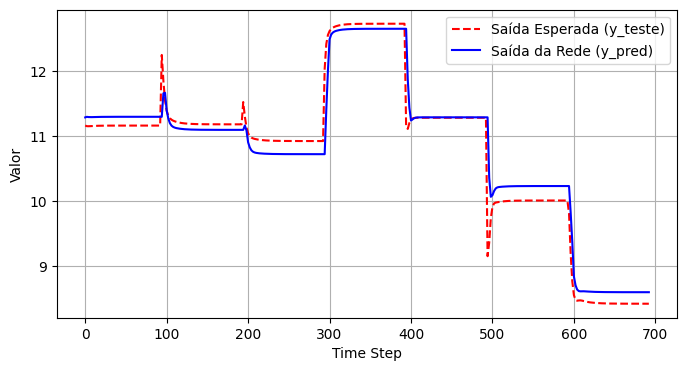

In [10]:
import matplotlib.pyplot as plt

time_steps = time_steps[:y_teste.shape[0]]
# Remover dimensões extras de y_pred (se houver)
y_pred = y_pred.squeeze()
y_teste = y_teste.squeeze()
# Número de variáveis de saída
num_outputs = y_teste.shape[1]  

# Gerar 14 gráficos separadamente
plt.figure(figsize=(8, 4))  # Criar uma nova figura para cada gráfico
print(y_teste.shape)
plt.plot(time_steps, y_teste[:,0], label="Saída Esperada (y_teste)", color="red", linestyle="--")
plt.plot(time_steps, y_pred[:, 0], label="Saída da Rede (y_pred)", color="blue", linestyle="-")

plt.xlabel("Time Step")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)

plt.show()  # Mostrar cada gráfico individualmente
